In [1]:
# Sys.setLanguage("en")   # Remove as necessary for others
suppressPackageStartupMessages({
library(haven)    # Loading of .dta datasets
library(tidyverse)
library(dplyr)
library(datasets)
library(car)
# install.packages("vtable")    # maybe needed if not installed
# install.packages("corrplot")  # maybe needed if not installed
# install.packages("sandwich")  # maybe needed if not installed
# install.packages("lmtest")    # maybe needed if not installed
library(vtable)
library(corrplot)
library(sandwich)
library(lmtest)
library(repr)
library(tidymodels)
# install.packages("stargazer")      # maybe needed if not installed
library(stargazer)
library(purrr)
library(modelr)
library(broom)
library(infer)
library(GGally)
library(coefplot)
})

## Introduction & Data Description

The assigned dataset for the project is the Customer Personality Analysis found on https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/data. In this project, the code below show the descriptive summary of the dataset. There are 2240 observations and 28 variables which captures various attrributes about customers which includes their demographic information, responses to marketing campaigns and purchase history.

In [2]:
# Read the CSV file with specified column types 
market_data <- as_factor(read_delim("https://raw.githubusercontent.com/DrakenRaptor/STAT301_ProjectGrp26/refs/heads/main/marketing_campaign.csv", delim = "\t"))

# Check the structure of data types 
str(market_data)

head(market_data)


Rows: 2240 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): Education, Marital_Status, Dt_Customer
dbl (26): ID, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


spc_tbl_ [2,240 × 29] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ID                 : num [1:2240] 5524 2174 4141 6182 5324 ...
 $ Year_Birth         : num [1:2240] 1957 1954 1965 1984 1981 ...
 $ Education          : chr [1:2240] "Graduation" "Graduation" "Graduation" "Graduation" ...
 $ Marital_Status     : chr [1:2240] "Single" "Single" "Together" "Together" ...
 $ Income             : num [1:2240] 58138 46344 71613 26646 58293 ...
 $ Kidhome            : num [1:2240] 0 1 0 1 1 0 0 1 1 1 ...
 $ Teenhome           : num [1:2240] 0 1 0 0 0 1 1 0 0 1 ...
 $ Dt_Customer        : chr [1:2240] "04-09-2012" "08-03-2014" "21-08-2013" "10-02-2014" ...
 $ Recency            : num [1:2240] 58 38 26 26 94 16 34 32 19 68 ...
 $ MntWines           : num [1:2240] 635 11 426 11 173 520 235 76 14 28 ...
 $ MntFruits          : num [1:2240] 88 1 49 4 43 42 65 10 0 0 ...
 $ MntMeatProducts    : num [1:2240] 546 6 127 20 118 98 164 56 24 6 ...
 $ MntFishProducts    : num [1:2240] 172 2 111 10 46 0 50 3

ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,⋯,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5524,1957,Graduation,Single,58138,0,0,04-09-2012,58,635,⋯,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344,1,1,08-03-2014,38,11,⋯,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613,0,0,21-08-2013,26,426,⋯,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646,1,0,10-02-2014,26,11,⋯,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293,1,0,19-01-2014,94,173,⋯,5,0,0,0,0,0,0,3,11,0
7446,1967,Master,Together,62513,0,1,09-09-2013,16,520,⋯,6,0,0,0,0,0,0,3,11,0


## Research Question (Question of Interest)

How is customer income related to their spending patterns, specifically the number of web purchases, catalog purchases, store purchases, and website visits, and how do education level and marital status influence these spending behaviors?

**<br> Legend:**
- `Income` is the response variable where it measured in USD.
- `Education` is a qualitative variable that takes 4 values for different level of education as in the code below.
- `Marital_Status` is a dummy variable that indicates `1` if the respondent is married, otherwise 0.
- `NumWebPurchases` is 
- `NumCatalogPurchases` 
- `NumStorePurchases`
- `NumWebVisitsMonth` are explanatory variables 

In [3]:
unique(market_data$Education)   # Possible covariates to be used as factor variables for research model
unique(market_data$Marital_Status)     # Possible covariates to be used as factor variables for research model, to classify YOLO as single?

[1] "Graduation" "PhD"        "Master"     "Basic"      "2n Cycle"

[1] "Single"   "Together" "Married"  "Divorced" "Widow"    "Alone"    "Absurd"  
[8] "YOLO"

In [4]:
# Check for 2n Cycle education count, 2n cycle is the same as Master's degree
# TO reclassify them as Master's degree
specific_2n_count <- market_data %>%
  filter(Education == "2n Cycle") |>
  count()

specific_2n_count

# Reclassify 2n Cycle as Master's degree using case_when
market_data <- market_data %>%
    mutate(Education = case_when(
        Education == "2n Cycle" ~ "Master",
        TRUE ~ Education
    ))

unique(market_data$Education)   # Check if 2n Cycle has been reclassified as Master's degree

# Reclassify YOLO, Absurd, Togethe, Alone as single, since it is the same as single
market_data <- market_data %>%
    mutate(Marital_Status = case_when(
        Marital_Status == "YOLO" ~ "Single",
        Marital_Status == "Absurd" ~ "Single",
        Marital_Status == "Together" ~ "Single",
        Marital_Status == "Alone" ~ "Single",
        TRUE ~ Marital_Status
    ))
  
unique(market_data$Marital_Status)   # Check if YOLO, Absurd, Together, Alone has been reclassified as Single


n
<int>
203


[1] "Graduation" "PhD"        "Master"     "Basic"

[1] "Single"   "Married"  "Divorced" "Widow"

### EDA and Visualisation

A scatterplot may be suitable to visualise the relationships between different variables in the data set by splitting the data into groups and displaying each group in its own plot.

Warning message:
“Removed 24 rows containing missing values or values outside the scale range
(`geom_point()`).”


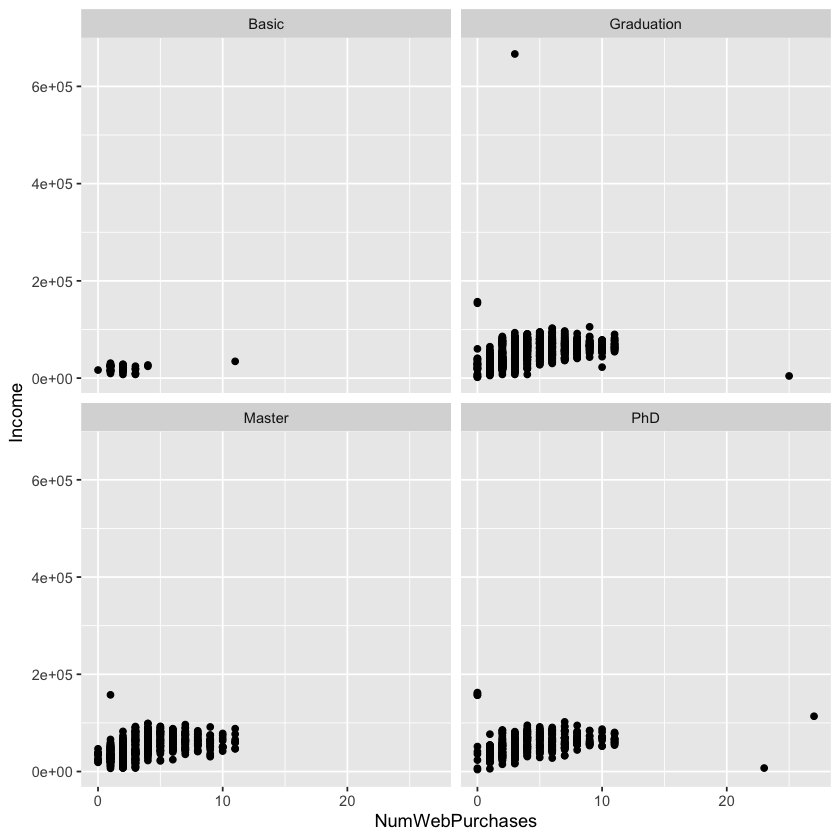

In [5]:
facet_single <- market_data  |>
    ggplot(aes(x = NumWebPurchases, y = Income)) +
    geom_point() +
    facet_wrap(~ Education)

facet_single

Warning message:
“Removed 24 rows containing missing values or values outside the scale range
(`geom_point()`).”


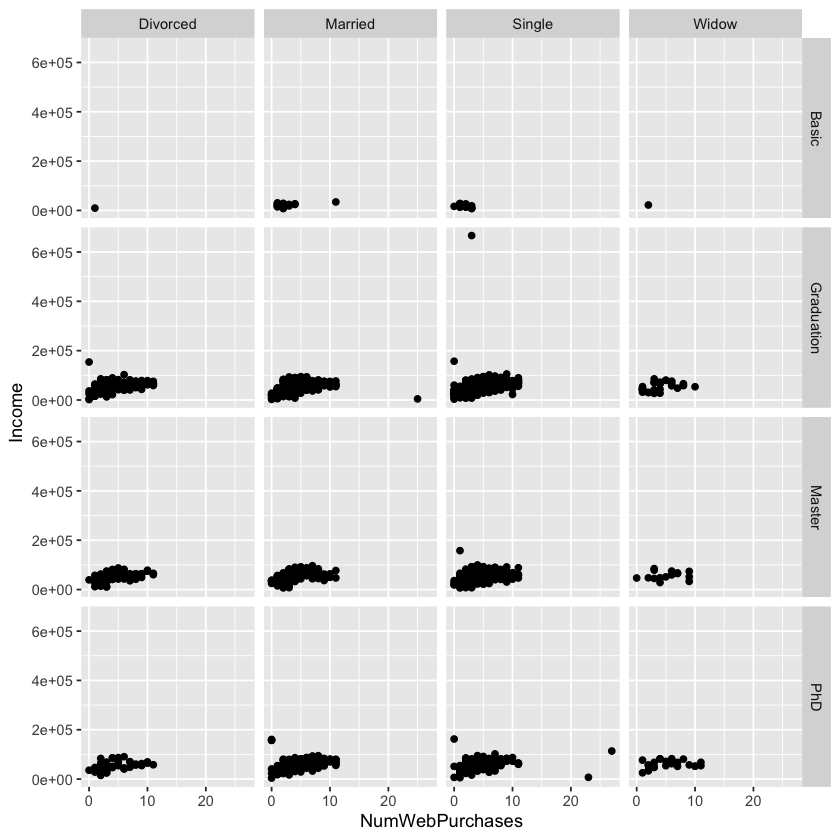

In [6]:
facet_double <- market_data  |>
    ggplot(aes(x = NumWebPurchases, y = Income)) +
    geom_point() +
    facet_grid(Education ~ Marital_Status)

facet_double

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 72 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 72 rows containing missing values or values outside the scale range
(`geom_point()`).”


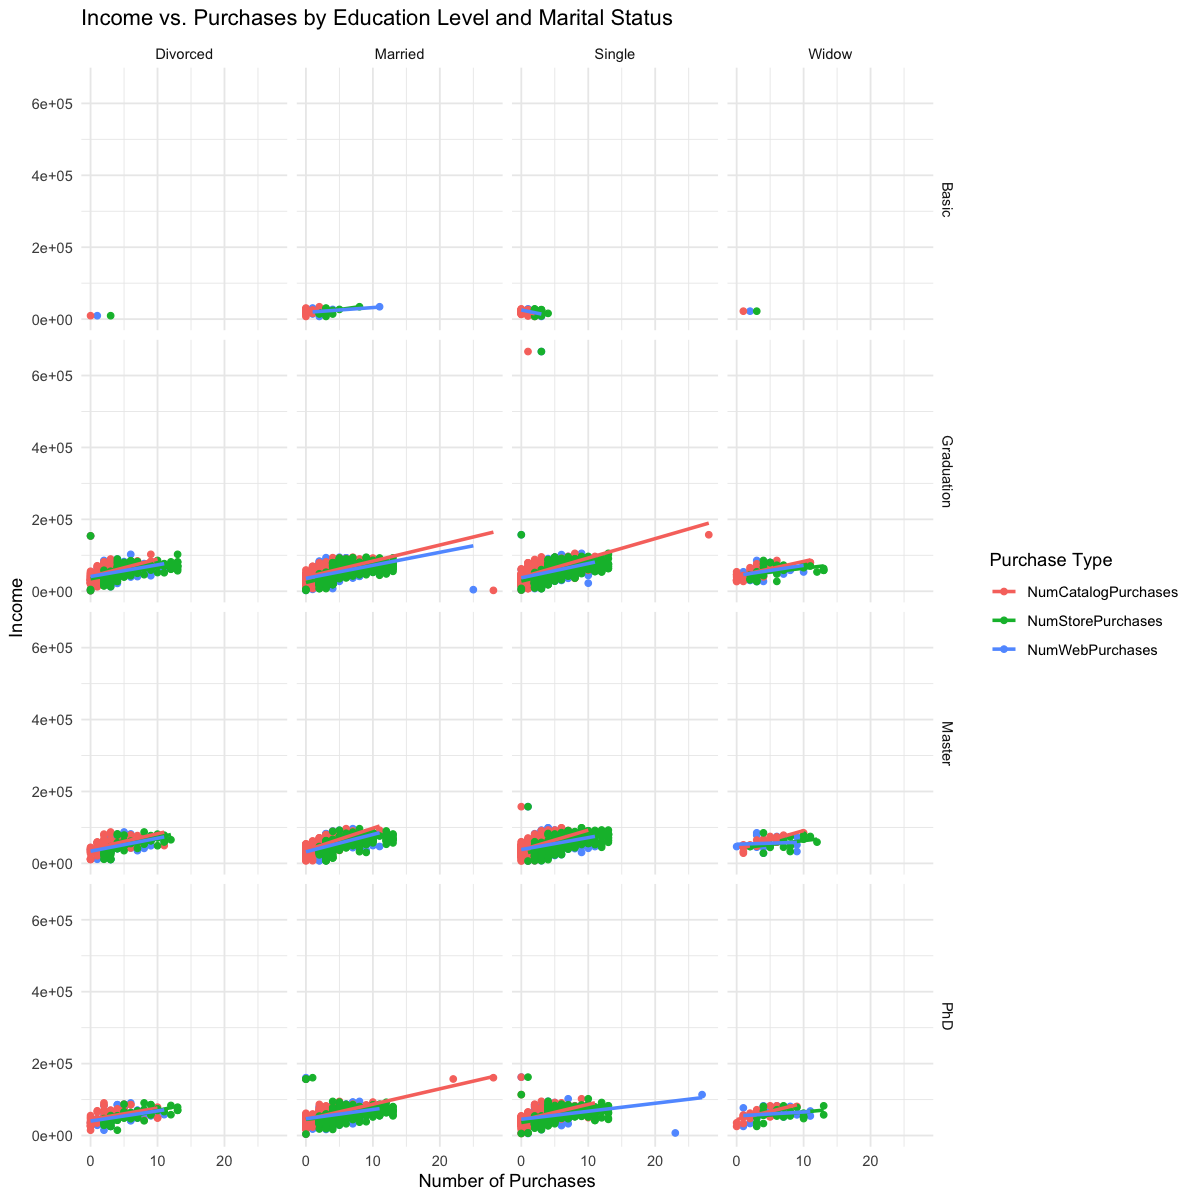

In [9]:
options(repr.plot.width = 10, repr.plot.height = 10)
# Reshape the data to long format for easier plotting
data_long <- market_data |>
  gather(key = "PurchaseType", value = "PurchaseCount",
         NumWebPurchases, NumCatalogPurchases, NumStorePurchases)

# Create the faceted scatter plot with regression lines
ggplot(data_long, aes(x = PurchaseCount, y = Income, color = PurchaseType)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE) +
  facet_grid(Education ~ Marital_Status) +
  labs(title = "Income vs. Purchases by Education Level and Marital Status",
       x = "Number of Purchases",
       y = "Income",
       color = "Purchase Type") +
  theme_minimal()  # Aesthetics
